<a href="https://colab.research.google.com/github/mateusmarquessz/TCC/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importação de bibliotecas necessárias
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet201, ResNet50V2, EfficientNetB0, MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


In [ ]:
# Configuração inicial
IMG_SIZE = (512, 512)
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 4  # Número de classes: normal, stone, cyst, tumor

In [ ]:
# Diretórios dos dados
TRAIN_DIR = '/content/drive/MyDrive/TCC/train'
VAL_DIR = '/content/drive/MyDrive/TCC/val'
TEST_DIR = '/content/drive/MyDrive/TCC/test'

In [ ]:
# Função para carregar dados
def load_data(train_dir, val_dir, test_dir, img_size, batch_size):
    # Data augmentation para o conjunto de treinamento
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,  # Rotação leve
        width_shift_range=0.1,  # Pequeno deslocamento horizontal
        height_shift_range=0.1,  # Pequeno deslocamento vertical
        shear_range=0.1,  # Transformação leve de cisalhamento
        zoom_range=0.1,  # Pequeno zoom
        horizontal_flip=True,  # Flip horizontal
        fill_mode='nearest'
    )

    # Apenas normalização para validação e teste
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Carregar os dados
    train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale'  # Alterar para escala de cinza
    )

    val_data = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale'  # Alterar para escala de cinza
    )

    test_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'  # Alterar para escala de cinza
    )

    return train_data, val_data, test_data

# Carregar dados
train_data, val_data, test_data = load_data(TRAIN_DIR, VAL_DIR, TEST_DIR, IMG_SIZE, BATCH_SIZE)
class_names = list(train_data.class_indices.keys())

Found 8000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


In [ ]:
def dense_block(x, num_layers, growth_rate):
    """
    Bloco denso: aplica várias camadas convolucionais com conexões densas.
    """
    for _ in range(num_layers):
        shortcut = x
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(4 * growth_rate, (1, 1), padding='same', use_bias=False)(x)  # Bottleneck
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(x)  # 3x3 Convolution
        x = layers.Concatenate()([x, shortcut])  # Conexão Densa
    return x

def transition_layer(x, reduction):
    """
    Camada de transição para reduzir as dimensões após um bloco denso.
    """
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    num_filters = int(x.shape[-1] * reduction)
    x = layers.Conv2D(num_filters, (1, 1), padding='same', use_bias=False)(x)
    x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x

def DenseNet201(input_shape, num_classes, growth_rate=32, reduction=0.5):
    """
    Implementação completa da arquitetura DenseNet201.
    """
    inputs = layers.Input(shape=input_shape)

    # Camada inicial
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Blocos densos e camadas de transição
    x = dense_block(x, num_layers=6, growth_rate=growth_rate)  # Primeiro bloco denso
    x = transition_layer(x, reduction)

    x = dense_block(x, num_layers=12, growth_rate=growth_rate)  # Segundo bloco denso
    x = transition_layer(x, reduction)

    x = dense_block(x, num_layers=48, growth_rate=growth_rate)  # Terceiro bloco denso
    x = transition_layer(x, reduction)

    x = dense_block(x, num_layers=32, growth_rate=growth_rate)  # Quarto bloco denso

    # Camada de Pooling Global e Saída
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Modelo final
    model = models.Model(inputs, outputs)
    return model

# Compilação e treinamento do DenseNet201
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 1)
densenet201_model = DenseNet201(input_shape, NUM_CLASSES)

# Compilar o modelo
densenet201_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Callback de parada antecipada
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Treinamento com EarlyStopping
history_densenet = densenet201_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stopping]  # Adicionando o callback de parada antecipada
)

# Avaliação
test_loss, test_accuracy = densenet201_model.evaluate(test_data)
print(f"DenseNet201 - Loss: {test_loss}, Accuracy: {test_accuracy}")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 6619s 24s/step - accuracy: 0.8162 - loss: 0.4749 - val_accuracy: 0.2500 - val_loss: 11.4532
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 170s 661ms/step - accuracy: 0.9813 - loss: 0.0706 - val_accuracy: 0.2500 - val_loss: 13.6859
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 169s 658ms/step - accuracy: 0.9839 - loss: 0.0520 - val_accuracy: 0.7385 - val_loss: 0.9848
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 170s 661ms/step - accuracy: 0.9893 - loss: 0.0316 - val_accuracy: 0.8060 - val_loss: 0.7308
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 171s 666ms/step - accuracy: 0.9895 - loss: 0.0317 - val_accuracy: 0.8655 - val_loss: 0.5687
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 170s 661ms/step - accuracy: 0.9951 - loss: 0.0173 - val_accuracy: 0.8245 - val_loss: 0.9528
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 170s 661ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9190 - val_loss: 0.4198
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 170s 662ms/step - accuracy: 0.9988 - loss: 0.0

In [ ]:
# Construção do modelo ResNet50V2
def build_resnet50v2(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Primeira camada de convolução e max pooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)  # Normalização antes da ReLU
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Função para o bloco residual com pre-activation
    def residual_block(x, filters, strides=1):
        shortcut = x
        x = layers.BatchNormalization()(x)  # Normalização antes da ReLU
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same')(x)

        x = layers.BatchNormalization()(x)  # Normalização após a primeira convolução
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)

        if strides != 1:
            shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)

        x = layers.Add()([x, shortcut])  # Adição do atalho
        return x

    # Adicionando blocos residuais com diferentes números de filtros
    x = residual_block(x, filters=64, strides=1)
    x = residual_block(x, filters=128, strides=2)  # Downsampling
    x = residual_block(x, filters=256, strides=2)
    x = residual_block(x, filters=512, strides=2)

    # Camada de Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Camada densa de saída
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Construindo o modelo
    model = models.Model(inputs=inputs, outputs=outputs)
    return model


resnet_model = build_resnet50v2(input_shape, NUM_CLASSES)
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callback de parada antecipada
early_stopping = EarlyStopping(
    monitor='val_loss',       # Métrica monitorada (val_loss ou val_accuracy)
    patience=5,               # Número de épocas sem melhoria antes de parar
    restore_best_weights=True # Restaura os melhores pesos ao final do treinamento
)

# Treinamento com EarlyStopping
history_resnet = resnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stopping]  # Adicionando o callback
)

# Avaliação
test_loss, test_accuracy = resnet_model.evaluate(test_data)
print(f"ResNet50V2 - Loss: {test_loss}, Accuracy: {test_accuracy}")

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 190s 667ms/step - accuracy: 0.5476 - loss: 4.1390 - val_accuracy: 0.2500 - val_loss: 18.0517
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 167s 650ms/step - accuracy: 0.8059 - loss: 0.5431 - val_accuracy: 0.2560 - val_loss: 5.6603
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 646ms/step - accuracy: 0.8524 - loss: 0.4758 - val_accuracy: 0.7125 - val_loss: 1.6612
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 646ms/step - accuracy: 0.9263 - loss: 0.2148 - val_accuracy: 0.3885 - val_loss: 9.6966
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 165s 644ms/step - accuracy: 0.9141 - loss: 0.2527 - val_accuracy: 0.5945 - val_loss: 3.2483
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 645ms/step - accuracy: 0.9496 - loss: 0.1626 - val_accuracy: 0.8230 - val_loss: 0.7447
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 165s 644ms/step - accuracy: 0.9682 - loss: 0.1096 - val_accuracy: 0.8015 - val_loss: 0.8742
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 646ms/step - accuracy: 0.9813 

In [ ]:
# Função para construir o modelo EfficientNetB0 do zero
def build_efficientnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Primeira Convolução
    x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='swish')(inputs)
    x = layers.BatchNormalization()(x)

    # Função para o bloco MBConv
    def mbconv_block(x, inputs, filters, expand_ratio=6, stride=1):
        input_channels = x.shape[-1]
        expanded_channels = input_channels * expand_ratio

        # Expansão (se expand_ratio > 1)
        if expand_ratio > 1:
            x = layers.Conv2D(expanded_channels, (1, 1), padding='same', activation='swish')(inputs)
            x = layers.BatchNormalization()(x)
        else:
            x = inputs
        # Convolução depthwise
        x = layers.DepthwiseConv2D((3, 3), strides=stride, padding='same', activation='swish')(x)
        x = layers.BatchNormalization()(x)

        # Projeção
        x = layers.Conv2D(filters, (1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Skip connection (conexão de atalho)
        if stride == 1 and inputs.shape[-1] == filters:
            x = layers.Add()([x, inputs])

        return x

    # Sequência dos blocos MBConv para a EfficientNetB0
    x = mbconv_block(x, x, filters=16, expand_ratio=1, stride=1)
    x = mbconv_block(x, x, filters=24, expand_ratio=6, stride=2)
    x = mbconv_block(x, x, filters=40, expand_ratio=6, stride=2)
    x = mbconv_block(x, x, filters=80, expand_ratio=6, stride=2)
    x = mbconv_block(x, x, filters=112, expand_ratio=6, stride=1)
    x = mbconv_block(x, x, filters=192, expand_ratio=6, stride=2)
    x = mbconv_block(x, x, filters=320, expand_ratio=6, stride=1)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Camada densa
    x = layers.Dense(1280, activation='swish')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Construir o modelo
efficientnet_model = build_efficientnet(input_shape, NUM_CLASSES)

# Compilar o modelo
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callback de parada antecipada
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica monitorada (val_loss ou val_accuracy)
    patience=5,  # Número de épocas sem melhoria antes de parar
    restore_best_weights=True  # Restaura os melhores pesos ao final do treinamento
)

# Treinamento com EarlyStopping
history_efficientnet = efficientnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stopping]  # Adicionando o callback
)

# Avaliação
test_loss, test_accuracy = efficientnet_model.evaluate(test_data)
print(f"EfficientNetB0 - Loss: {test_loss}, Accuracy: {test_accuracy}")


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 211s 670ms/step - accuracy: 0.6601 - loss: 0.7948 - val_accuracy: 0.2500 - val_loss: 2.1353
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 648ms/step - accuracy: 0.8760 - loss: 0.3320 - val_accuracy: 0.3215 - val_loss: 14.6850
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 645ms/step - accuracy: 0.9288 - loss: 0.1870 - val_accuracy: 0.6220 - val_loss: 1.5178
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 647ms/step - accuracy: 0.9536 - loss: 0.1220 - val_accuracy: 0.7885 - val_loss: 1.2139
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 646ms/step - accuracy: 0.9682 - loss: 0.0924 - val_accuracy: 0.7385 - val_loss: 1.2991
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 648ms/step - accuracy: 0.9800 - loss: 0.0641 - val_accuracy: 0.5255 - val_loss: 4.0425
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 167s 652ms/step - accuracy: 0.9781 - loss: 0.0666 - val_accuracy: 0.7000 - val_loss: 1.8750
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 167s 650ms/step - accuracy: 0.9808 

In [ ]:

# Função para construir o modelo MobileNetV3 Large
def build_mobilenetv3_large(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Primeira camada de convolução com ReLU6
    x = layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same')(inputs)
    x = layers.Activation('relu6')(x)

    def inverted_residual_block(x, filters, expand_ratio, strides, use_h_swish=False):
        input_channels = x.shape[-1]
        expanded_channels = input_channels * expand_ratio

        # Expansão de canal com ReLU6 ou H-Swish
        x = layers.Conv2D(expanded_channels, (1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        if use_h_swish:
            x = layers.Activation('swish')(x)  # H-swish
        else:
            x = layers.Activation('relu6')(x)  # ReLU6

        # Convolução depthwise com H-swish
        x = layers.DepthwiseConv2D((3, 3), strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)
        if use_h_swish:
            x = layers.Activation('swish')(x)  # H-swish
        else:
            x = layers.Activation('relu6')(x)  # ReLU6

        # Redução de canal
        x = layers.Conv2D(filters, (1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        return x

    # Adicionando blocos invertidos com configurações do MobileNetV3 Large
    x = inverted_residual_block(x, filters=16, expand_ratio=1, strides=1, use_h_swish=False)
    x = inverted_residual_block(x, filters=24, expand_ratio=4, strides=2, use_h_swish=False)
    x = inverted_residual_block(x, filters=40, expand_ratio=4, strides=2, use_h_swish=True)
    x = inverted_residual_block(x, filters=80, expand_ratio=6, strides=2, use_h_swish=True)
    x = inverted_residual_block(x, filters=112, expand_ratio=6, strides=1, use_h_swish=True)
    x = inverted_residual_block(x, filters=160, expand_ratio=6, strides=2, use_h_swish=True)
    x = inverted_residual_block(x, filters=960, expand_ratio=6, strides=1, use_h_swish=True)

    # Camada Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Camada final de classificação
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


mobilenetv3_model = build_mobilenetv3_large(input_shape, NUM_CLASSES)
mobilenetv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callback de parada antecipada
early_stopping = EarlyStopping(
    monitor='val_loss',       # Métrica monitorada (val_loss ou val_accuracy)
    patience=5,               # Número de épocas sem melhoria antes de parar
    restore_best_weights=True # Restaura os melhores pesos ao final do treinamento
)



# Treinamento com EarlyStopping
history_mobilenetv3 = mobilenetv3_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stopping]  # Adicionando o callback
)

# Avaliação
test_loss, test_accuracy = mobilenetv3_model.evaluate(test_data)
print(f"MobileNetV3Large - Loss: {test_loss}, Accuracy: {test_accuracy}")

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 201s 664ms/step - accuracy: 0.7567 - loss: 0.6304 - val_accuracy: 0.2500 - val_loss: 2.8116
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 644ms/step - accuracy: 0.9481 - loss: 0.1570 - val_accuracy: 0.2500 - val_loss: 7.9455
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 647ms/step - accuracy: 0.9687 - loss: 0.0866 - val_accuracy: 0.8845 - val_loss: 0.3819
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 648ms/step - accuracy: 0.9759 - loss: 0.0610 - val_accuracy: 0.6080 - val_loss: 1.9614
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 648ms/step - accuracy: 0.9889 - loss: 0.0329 - val_accuracy: 0.6530 - val_loss: 2.0627
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 647ms/step - accuracy: 0.9780 - loss: 0.0683 - val_accuracy: 0.9485 - val_loss: 0.2478
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 646ms/step - accuracy: 0.9890 - loss: 0.0355 - val_accuracy: 0.8150 - val_loss: 0.9309
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 166s 647ms/step - accuracy: 0.9927 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step

Relatório de Classificação - DenseNet201
--------------------------------------------------
╒══════════════╤════════════╤══════════╤════════════╤════════════╕
│ Classe       │ Precisão   │ Recall   │ F1-Score   │ Amostras   │
╞══════════════╪════════════╪══════════╪════════════╪════════════╡
│ cyst         │ 0.8971     │ 0.6100   │ 0.7262     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ normal       │ 0.5727     │ 1.0000   │ 0.7283     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ stone        │ 0.8810     │ 0.8880   │ 0.8845     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ tumor        │ 0.9788     │ 0.5540   │ 0.7075     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ Accuracy     │ -          │ -        │ -          │ 0.7630     │
├──────────────┼────────────┼──────────┼────────────┼────────

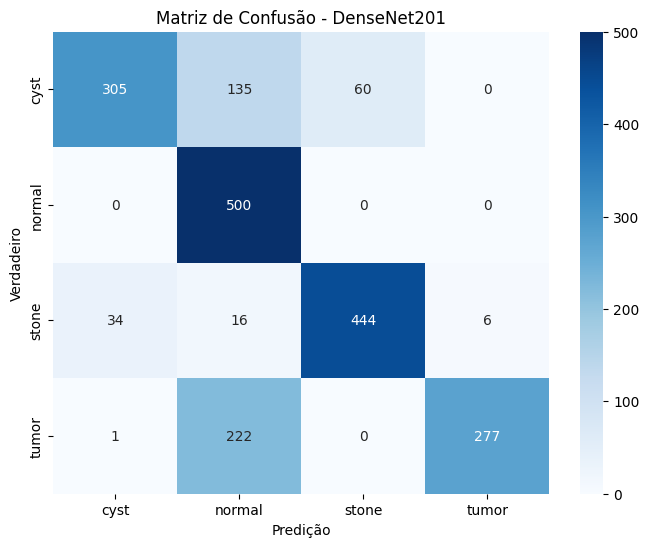

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step

Relatório de Classificação - ResNet50V2
--------------------------------------------------
╒══════════════╤════════════╤══════════╤════════════╤════════════╕
│ Classe       │ Precisão   │ Recall   │ F1-Score   │ Amostras   │
╞══════════════╪════════════╪══════════╪════════════╪════════════╡
│ cyst         │ 0.8542     │ 0.9140   │ 0.8831     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ normal       │ 0.6530     │ 0.7940   │ 0.7166     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ stone        │ 0.8078     │ 0.9160   │ 0.8585     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ tumor        │ 0.8345     │ 0.4840   │ 0.6127     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ Accuracy     │ -          │ -        │ -          │ 0.7770     │
├──────────────┼────────────┼──────────┼────────────┼─────────

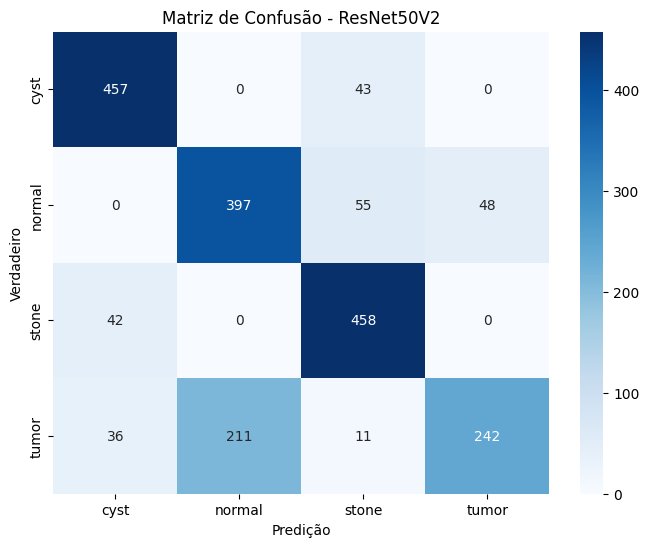

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step

Relatório de Classificação - EfficientNet
--------------------------------------------------
╒══════════════╤════════════╤══════════╤════════════╤════════════╕
│ Classe       │ Precisão   │ Recall   │ F1-Score   │ Amostras   │
╞══════════════╪════════════╪══════════╪════════════╪════════════╡
│ cyst         │ 0.9224     │ 0.6180   │ 0.7401     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ normal       │ 0.6757     │ 0.9960   │ 0.8052     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ stone        │ 0.7097     │ 0.9340   │ 0.8066     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ tumor        │ 0.9926     │ 0.5360   │ 0.6961     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ Accuracy     │ -          │ -        │ -          │ 0.7710     │
├──────────────┼────────────┼──────────┼────────────┼───────

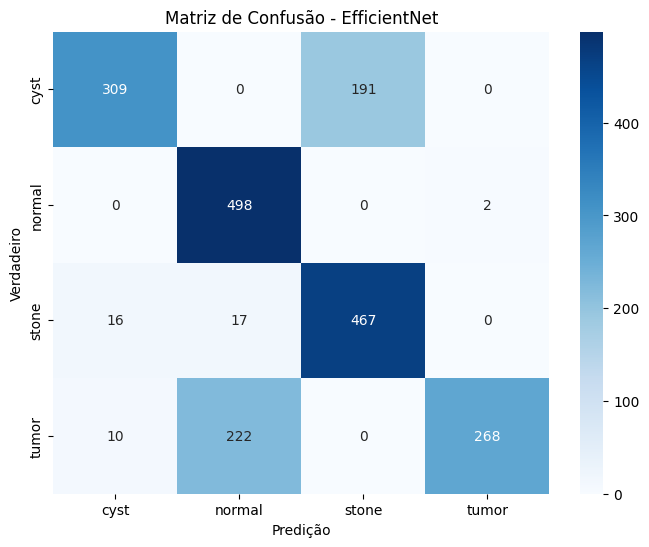

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step

Relatório de Classificação - MobileNetV3
--------------------------------------------------
╒══════════════╤════════════╤══════════╤════════════╤════════════╕
│ Classe       │ Precisão   │ Recall   │ F1-Score   │ Amostras   │
╞══════════════╪════════════╪══════════╪════════════╪════════════╡
│ cyst         │ 0.8929     │ 0.9840   │ 0.9363     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ normal       │ 0.6685     │ 0.9480   │ 0.7841     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ stone        │ 0.9841     │ 0.8680   │ 0.9224     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ tumor        │ 0.9130     │ 0.5460   │ 0.6834     │ 500.0      │
├──────────────┼────────────┼──────────┼────────────┼────────────┤
│ Accuracy     │ -          │ -        │ -          │ 0.8365     │
├──────────────┼────────────┼──────────┼────────────┼────────

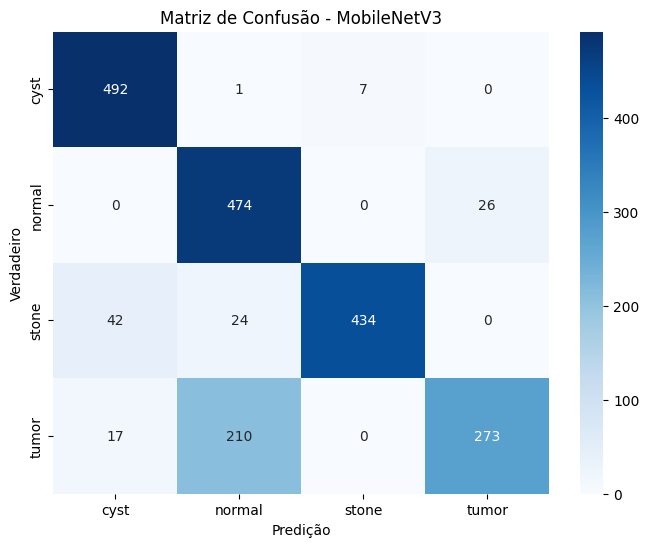

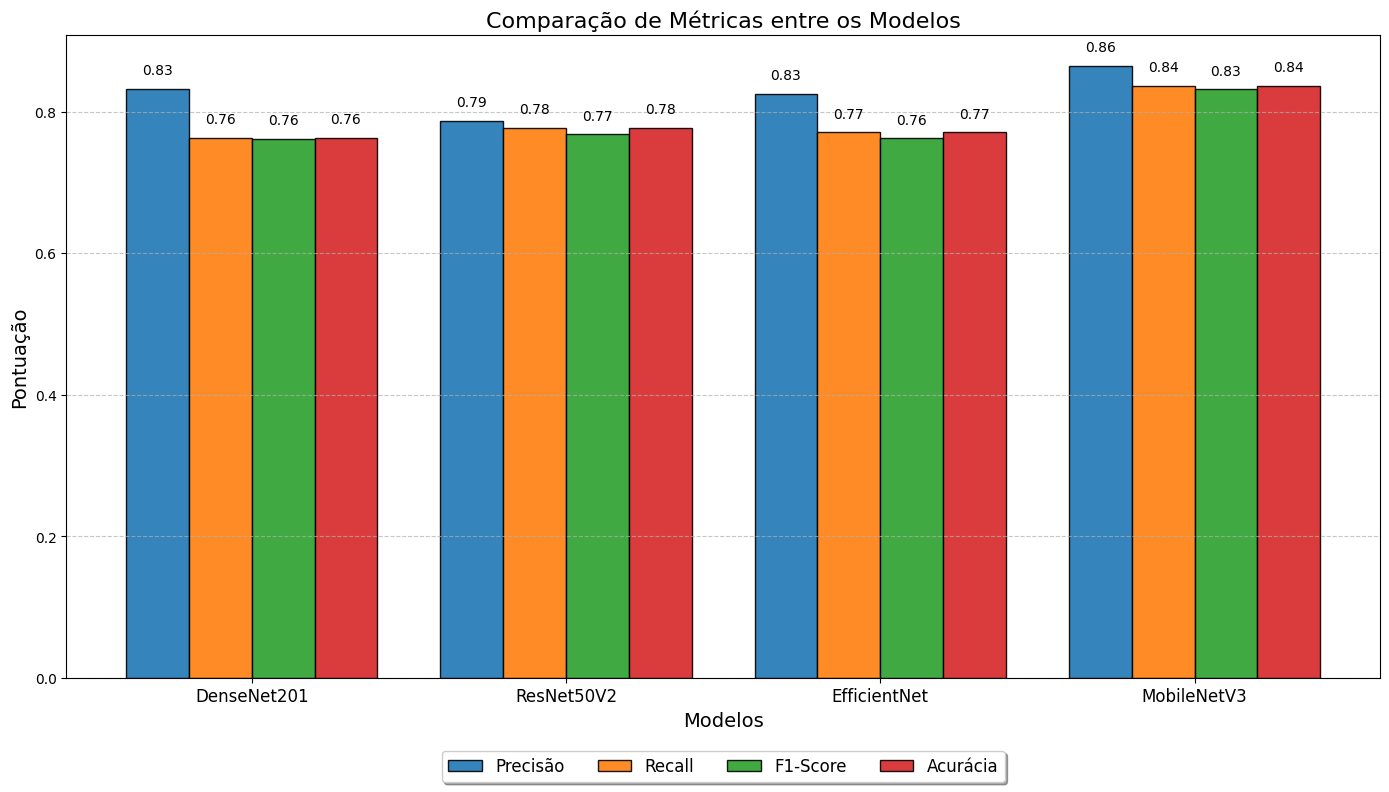

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from tabulate import tabulate

def evaluate_model(model, test_data, class_names, model_name):
    # Predições do modelo
    y_pred = np.argmax(model.predict(test_data), axis=1)
    y_true = test_data.classes

    # Relatório de classificação detalhado
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # Tabela para métricas de cada classe
    class_metrics = [
        [class_name,
         f"{report_dict[class_name]['precision']:.4f}",
         f"{report_dict[class_name]['recall']:.4f}",
         f"{report_dict[class_name]['f1-score']:.4f}",
         f"{report_dict[class_name]['support']}"]
        for class_name in class_names
    ]

    # Adicionar métricas globais
    overall_metrics = [
        ["Accuracy", "-", "-", "-", f"{report_dict['accuracy']:.4f}"],
        ["Macro Avg",
         f"{report_dict['macro avg']['precision']:.4f}",
         f"{report_dict['macro avg']['recall']:.4f}",
         f"{report_dict['macro avg']['f1-score']:.4f}",
         "-"],
        ["Weighted Avg",
         f"{report_dict['weighted avg']['precision']:.4f}",
         f"{report_dict['weighted avg']['recall']:.4f}",
         f"{report_dict['weighted avg']['f1-score']:.4f}",
         "-"]
    ]

    # Exibir relatório formatado
    print(f"\n{'=' * 50}")
    print(f"Relatório de Classificação - {model_name}")
    print(f"{'-' * 50}")
    print(tabulate(class_metrics + overall_metrics,
                   headers=["Classe", "Precisão", "Recall", "F1-Score", "Amostras"],
                   tablefmt="fancy_grid"))

    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predição')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()

    # Retornar métricas para uso posterior, incluindo acurácia
    return {
        'model': model_name,
        'precision': report_dict['weighted avg']['precision'],
        'recall': report_dict['weighted avg']['recall'],
        'f1': report_dict['weighted avg']['f1-score'],
        'accuracy': report_dict['accuracy']  # Adiciona a acurácia ao dicionário
    }


def compare_models(metrics):
    models = [m['model'] for m in metrics]
    precisions = [m['precision'] for m in metrics]
    recalls = [m['recall'] for m in metrics]
    f1_scores = [m['f1'] for m in metrics]
    accuracies = [m['accuracy'] for m in metrics]  # Adiciona a acurácia

    x = np.arange(len(models))  # Posições no eixo X
    width = 0.2  # Largura das barras (ajustada para 4 categorias)

    plt.figure(figsize=(14, 8))

    # Adiciona barras para cada métrica
    plt.bar(x - 1.5 * width, precisions, width, label='Precisão', color='#1f77b4', alpha=0.9, edgecolor='black')
    plt.bar(x - 0.5 * width, recalls, width, label='Recall', color='#ff7f0e', alpha=0.9, edgecolor='black')
    plt.bar(x + 0.5 * width, f1_scores, width, label='F1-Score', color='#2ca02c', alpha=0.9, edgecolor='black')
    plt.bar(x + 1.5 * width, accuracies, width, label='Acurácia', color='#d62728', alpha=0.9, edgecolor='black')

    # Configurações do gráfico
    plt.xlabel('Modelos', fontsize=14)
    plt.ylabel('Pontuação', fontsize=14)
    plt.title('Comparação de Métricas entre os Modelos', fontsize=16)
    plt.xticks(x, models, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Posicionar a legenda fora do gráfico
    plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, frameon=True, shadow=True)

    # Adicionar valores acima das barras
    for i in range(len(models)):
        plt.text(x[i] - 1.5 * width, precisions[i] + 0.02, f"{precisions[i]:.2f}", ha='center', fontsize=10)
        plt.text(x[i] - 0.5 * width, recalls[i] + 0.02, f"{recalls[i]:.2f}", ha='center', fontsize=10)
        plt.text(x[i] + 0.5 * width, f1_scores[i] + 0.02, f"{f1_scores[i]:.2f}", ha='center', fontsize=10)
        plt.text(x[i] + 1.5 * width, accuracies[i] + 0.02, f"{accuracies[i]:.2f}", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

# Avaliar modelos e coletar métricas
metrics = []
metrics.append(evaluate_model(densenet201_model, test_data, class_names, "DenseNet201"))
metrics.append(evaluate_model(resnet_model, test_data, class_names, "ResNet50V2"))
metrics.append(evaluate_model(efficientnet_model, test_data, class_names, "EfficientNet"))
metrics.append(evaluate_model(mobilenetv3_model, test_data, class_names, "MobileNetV3"))

# Comparação final das métricas
compare_models(metrics)
